## LangGraph Introduction and Basics

In [8]:
from dotenv import load_dotenv

load_dotenv()

import os
print(os.environ['OPENAI_API_KEY'][:20])

sk-proj-ELGdCU-ggNJg


## Simple non-AI graph example
Generate some random values, and sum them up.

In [10]:
import random
values = [random.randint(0, 10) for _ in range(10)]
print(f"Sum of values: {sum(values)}")

Sum of values: 37


In [11]:
# Define the state of the graph:
from typing import TypedDict

class State(TypedDict):
    num_values: int
    generated_values: list[int]
    result: int | None = None


In [12]:
import random

# Define the nodes in the graph:
def generate_values(state: State):
    values = [random.randint(0, 10) for _ in range(state["num_values"])]
    return {"generated_values": values}

def add(state: State):
    result = sum(state["generated_values"])
    return {"result": result}

In [13]:
# Define the graph:
from langgraph.graph import StateGraph
from langgraph.graph import START, END

graph_builder = StateGraph(State)
graph_builder.add_node("generate_values", generate_values)
graph_builder.add_node("add", add)

graph_builder.add_edge(START, "generate_values")
graph_builder.add_edge("generate_values", "add")
graph_builder.add_edge("add", END)

# Now graph is also a 'Runnable'
graph = graph_builder.compile()

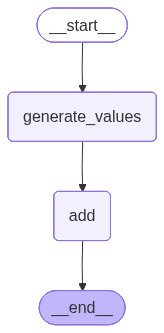

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
result = graph.invoke({"num_values": 10})

In [17]:
print(result)

{'num_values': 10, 'generated_values': [5, 2, 6, 5, 0, 6, 4, 6, 2, 0], 'result': 36}


In [18]:
await graph.ainvoke({"num_values": 10})

{'num_values': 10,
 'generated_values': [1, 3, 5, 8, 6, 5, 7, 3, 7, 4],
 'result': 49}

## Conditional Edge example in LangGraph

In [19]:
class ConditionalEdgeState(TypedDict):
    num_values: int
    generated_values: list[int]
    total: int
    # Prints happy if the total is even, sad if the total is odd
    final_message: str

def generate_values(state: ConditionalEdgeState):
    generated_values = [random.randint(0, 10) for _ in range(state["num_values"])]
    return {"generated_values": generated_values}

def add(state: ConditionalEdgeState):
    total = sum(state["generated_values"])
    return {"total": total}

def check_total(state: ConditionalEdgeState):
    if state["total"] % 2 == 0:
        return "happy_message"
    else:
        return "sad_message"
    
def happy_message(state: ConditionalEdgeState):
    return {"final_message": "happy"}

def sad_message(state: ConditionalEdgeState):
    return {"final_message": "sad"}

graph_builder = StateGraph(ConditionalEdgeState)

graph_builder.add_node("generate_values", generate_values)
graph_builder.add_node("add", add)
graph_builder.add_node("happy_message", happy_message)
graph_builder.add_node("sad_message", sad_message)

graph_builder.add_edge(START, "generate_values")
graph_builder.add_edge("generate_values", "add")
# THIS is the place where the condition is evaluated
graph_builder.add_conditional_edges(
    "add",
    check_total,
    {
        "happy_message": "happy_message",
        "sad_message": "sad_message",
    },
)
graph_builder.add_edge("happy_message", END)
graph_builder.add_edge("sad_message", END)

graph = graph_builder.compile()


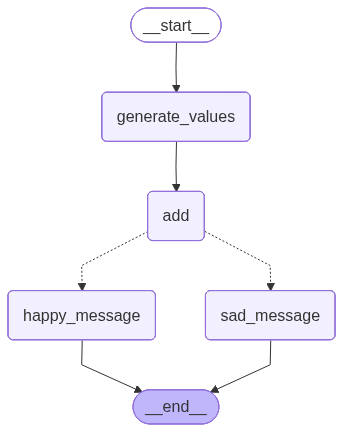

In [20]:
# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
graph.invoke({"num_values": 10})

{'num_values': 10,
 'generated_values': [4, 1, 0, 7, 0, 10, 3, 7, 5, 3],
 'total': 40,
 'final_message': 'happy'}

## Using LangChain Components in LangGraph
A simple sentiment analyzer that branches to happy or sad responses.


In [25]:
# Import LangChain components
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Initialize model and parser (can be used in LangGraph nodes!)
llm = init_chat_model("gpt-5-mini", model_provider="openai", reasoning_effort="minimal")
parser = StrOutputParser()


In [26]:
# Define state
class SentimentState(TypedDict):
    sentence: str
    sentiment: str
    message: str

# Node: Analyze sentiment
def analyze_sentiment(state: SentimentState):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Analyze sentiment. Reply with ONLY 'happy' or 'sad'."),
        ("user", "{sentence}")
    ])
    chain = prompt | llm | parser
    sentiment = chain.invoke({"sentence": state["sentence"]}).strip().lower()
    return {"sentiment": sentiment}

# Node: Generate happy message
def happy_response(state: SentimentState):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Generate a cheerful, uplifting message in 1 sentence."),
        ("user", "The person said: {sentence}")
    ])
    chain = prompt | llm | parser
    message = chain.invoke({"sentence": state["sentence"]})
    return {"message": message}

# Node: Generate sad message
def sad_response(state: SentimentState):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Generate a comforting message in 1 sentence that says it's alright."),
        ("user", "The person said: {sentence}")
    ])
    chain = prompt | llm | parser
    message = chain.invoke({"sentence": state["sentence"]})
    return {"message": message}


In [27]:
# Routing function: returns a ROUTE KEY (string) to determine which path to take
def route_sentiment(state: SentimentState):
    if "happy" in state["sentiment"]:
        return "positive_route"  # Route key for positive sentiment
    else:
        return "negative_route"  # Route key for negative sentiment

# Build the graph
builder = StateGraph(SentimentState)
builder.add_node("analyze_sentiment", analyze_sentiment)
builder.add_node("happy_response", happy_response)
builder.add_node("sad_response", sad_response)

builder.add_edge(START, "analyze_sentiment")

# Conditional edges: map route keys to node names
builder.add_conditional_edges(
    "analyze_sentiment",  # Source node
    route_sentiment,      # Routing function that returns a route key
    {
        # If route key is "positive_route", go to node "happy_response"
        "positive_route": "happy_response",
        # If route key is "negative_route", go to node "sad_response"
        "negative_route": "sad_response"
    }
)
builder.add_edge("happy_response", END)
builder.add_edge("sad_response", END)

sentiment_graph = builder.compile()


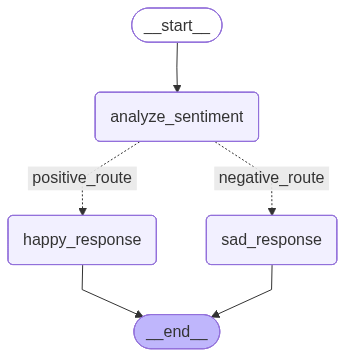

In [28]:
# Visualize the graph
display(Image(sentiment_graph.get_graph().draw_mermaid_png()))


In [29]:
# Example 1: Happy sentence
result = sentiment_graph.invoke({"sentence": "I got the job! I'm so excited!"})
print(f"Sentiment: {result['sentiment']}")
print(f"Message: {result['message']}")


Sentiment: happy
Message: That's fantastic—congratulations on the new job; your hard work paid off, and I can't wait to see all the amazing things you'll accomplish!


In [30]:
# Example 2: Sad sentence
result = sentiment_graph.invoke({"sentence": "I failed my exam and feel terrible."})
print(f"Sentiment: {result['sentiment']}")
print(f"Message: {result['message']}")


Sentiment: sad
Message: I'm so sorry you’re hurting right now — it’s alright to feel upset, and this one setback doesn’t define your worth or your future, so take the time you need, breathe, and know you can try again.


## Why LangGraph then where I can do everything in LangChain?
- THE central framework from LangChain company.
- Less opinionated, more flexibility. Can still use LangChain within the nodes of a graph.
- Contains many primitives for building AI agents over the next few weeks.

### Tracing with Arize

In [31]:
print(os.environ['OPENAI_API_KEY'][:10])
print(os.environ['ARIZE_API_KEY'][:10])
print(os.environ['ARIZE_SPACE_ID'][:10])

# Arize Imports
from arize.otel import register
from openinference.instrumentation.langchain import LangChainInstrumentor

# Register the project (this connects to Arize)
# 'project_name' creates a persistent project in your Arize dashboard
tracer_provider = register(
    space_id=os.environ["ARIZE_SPACE_ID"],
    api_key=os.environ["ARIZE_API_KEY"],
    project_name="langGraph-demo", 
)

# Instrument LangChain to send traces to the provider we just registered
LangChainInstrumentor(tracer_provider=tracer_provider).instrument()

print(f"Instrumentation active. Sending traces to Arize Cloud Project")

sk-proj-EL
ak-f5b3022
U3BhY2U6OT
🔭 OpenTelemetry Tracing Details 🔭
|  Arize Project: langGraph-demo
|  Span Processor: BatchSpanProcessor
|  Collector Endpoint: otlp.eu-west-1a.arize.com
|  Transport: gRPC
|  Transport Headers: {'authorization': '****', 'api_key': '****', 'arize-space-id': '****', 'space_id': '****', 'arize-interface': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

Instrumentation active. Sending traces to Arize Cloud Project


In [32]:
# Example 1: Happy sentence
result = sentiment_graph.invoke({"sentence": "I got the job! I'm so excited!"})
print(f"Sentiment: {result['sentiment']}")
print(f"Message: {result['message']}")

Sentiment: happy
Message: That's amazing—congratulations on the new job; your hard work paid off and this is just the beginning of wonderful things to come!


In [33]:
# Example 2: Sad sentence
result = sentiment_graph.invoke({"sentence": "I failed my exam and feel terrible."})
print(f"Sentiment: {result['sentiment']}")
print(f"Message: {result['message']}")

Sentiment: sad
Message: I'm so sorry—you’re allowed to feel upset, but it’s alright: one exam doesn’t define you, you can learn from this, and you’ll get through it.


In [40]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END

parser = StrOutputParser()

class State(TypedDict):
    question: str
    explanation: str
    summary: str


def explain_topic(state: State):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that can answer questions. You are concise and focus on the core of the question, you get to the root of the knowledge. Keep your responses to 2-3 sentences."),
        ("user", "{question}")
    ])
    chain = prompt | llm | parser
    explanation = chain.invoke({"question": state["question"]})
    return {"explanation": explanation}

def summarize_explanation(state: State):
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that can summarize explanations. You take concepts and summarise using language appropriate for a 5 year old. You break down longer topics into a single sentence."),
        ("user", "{explanation}")
    ])
    chain = prompt | llm | parser
    summary = chain.invoke({"explanation": state["explanation"]})
    return {"summary": summary}

graph_builder = StateGraph(State)

graph_builder.add_node("explain_topic", explain_topic)
graph_builder.add_node("summarize_explanation", summarize_explanation)

graph_builder.add_edge(START, "explain_topic")
graph_builder.add_edge("explain_topic", "summarize_explanation")
graph_builder.add_edge("summarize_explanation", END)

app = graph_builder.compile()

#display(Image(app.get_graph().draw_mermaid_png()))

app.invoke({"question": "What's the history of the all black rugby team?"})



{'question': "What's the history of the all black rugby team?",
 'explanation': 'The All Blacks are New Zealand’s national rugby union team, first formed for an 1884 tour of New South Wales; they adopted the black uniform and silver fern emblem early in the 20th century and became internationally famed after the 1905–06 “Originals” tour of Britain and France. Their name comes from the team’s all-black kit and a reported 1905 newspaper headline; they developed a distinctive running, expansive style and the haka (a Māori war dance) as a pre-match ritual, which became a central cultural symbol of the team. Dominant through much of the amateur and professional eras, key highlights include Rugby World Cup wins in 1987, 2011 and 2015, numerous Tri-Nations and Rugby Championship titles, and a legacy of producing many of the sport’s greatest players (e.g., Jonah Lomu, Dan Carter, Richie McCaw).',
 'summary': 'The All Blacks are New Zealand’s famous rugby team. They wear all black with a silver